In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import differential_evolution

In [2]:
# Confidence level etc
alpha = 0.05
beta = 1. - alpha
critical_chi_sq = chi2.isf(alpha, 2)
critical_loglike = 0.5 * critical_chi_sq
min_chi_sq = 0.

In [3]:
# Scan settings
n_random_samples = int(1e7)
dim = 4
min_ = -5.
max_ = 5.
seed = 127

# Color style for output sample points
de_pts = "#91bfdb" # Diver scan
rn_pts = "#fc8d59" # Random scan
gd_pts = "#ffffbf" # Grid scan


In [4]:
def rosenbrock(x, y):
    """
    @returns Rosenbrock function
    """
    a = 1.
    b = 100.
    return (a - x)**2 + b * (y - x**2)**2

def rosenbrock_general(x):
    """
    @returns Generalization of Rosenbrock function
    """
    n = len(x)
    return sum(rosenbrock(x[i], x[i+1]) for i in range(n - 1))

def loglike(x):
    """
    @returns Log-likelihood
    """
    return -rosenbrock_general(x)

def prior_transform(cube):
    """
    @returns Unit hypercube mapped to sample drawn from prior
    """
    return cube * (max_ - min_) + min_

def draw(dim, N):
    """
    @returns Samples drawn from prior
    """
    return prior_transform(np.random.rand(dim, N))

def grid(dim, N):
    """
    @returns Samples on a uniform grid
    """
    points_per_dim = int(N**(1. / dim))
    points = [points_per_dim] * dim
    grid = np.array(list(np.ndindex(*points)))
    grid = grid / grid.max()
    grid = prior_transform(grid)
    return grid.T

def samples_inside(x, chi_sq):
    """
    @returns Points from within delta chi-squared contour
    """
    delta_chi_sq = chi_sq - min_chi_sq
    inside = delta_chi_sq <= critical_chi_sq
    return x[:, inside]

def grid_scan(dim, N):
    """
    @returns Points from within delta chi-squared contour from grid scan and number of calls
    """
    x = grid(dim, N)
    chi_sq = -2. * loglike(x)
    return samples_inside(x, chi_sq), N

def random_scan(dim, N):
    """
    @returns Points from within delta chi-squared contour from random scan and number of calls
    """
    x = draw(dim, N)
    chi_sq = -2. * loglike(x)
    return samples_inside(x, chi_sq), N

def de_scan(dim, round_to_nearest=None):
    """
    @returns Points from within delta chi-squared contour from differential evolution
    and number of calls
    """
    bounds = [(min_, max_)] * dim
    x = []
    chi_sq = []

    def objective(x_):
        """
        @returns Objective for DE that saves chi-squared and parameters
        """
        chi_sq_ = -2. * loglike(x_)
        chi_sq.append(chi_sq_)
        x.append(x_)
        return chi_sq_

    differential_evolution(objective, bounds,
                           strategy='rand1bin', maxiter=None,
                           popsize=50, tol=0.01, mutation=(0.7, 1.99999), recombination=0.15,
                           polish=False, seed=seed)

    if round_to_nearest is not None:
        len_x = len(x)
        keep_n = len_x - (len_x % round_to_nearest)
        x = x[:keep_n]
        chi_sq = chi_sq[:keep_n]

    return samples_inside(np.array(x).T, np.array(chi_sq)), len(x)

def analytic_x_4d(y, level):
    """
    @returns Analytic solutions for x as function of y on contour

    Trivial to solve for x_3 and x_4. Solutions for x_1 as function of x_2 are
    solutions to a quartic.
    """
    coeffs = np.array([100.,
                       0.,
                       1. - 200. * y,
                       -2., (y * (100. * y**3 + 10001. * y - 202.) + 302.) / 101.])
    coeffs[-1] -= level
    roots = np.roots(coeffs)
    real_roots = roots[np.isclose(roots.imag, 0.)].real
    real_roots.sort()

    if len(real_roots) != 2:
        return [None, None]

    return real_roots

def analytic_4d(level):
    """
    @returns Analytic result for contour
    """
    y = np.linspace(-0.25, 1.75, 100000)
    x = [analytic_x_4d(y_, level) for y_ in y]
    x1, x2 = zip(*x)
    return (x1, x2, y)

Running de_scan
time =  11.220191955566406
Plotting de_scan
Running random_scan
time =  0.6840031147003174
Plotting random_scan
Running grid_scan
time =  6.5186614990234375
Plotting grid_scan


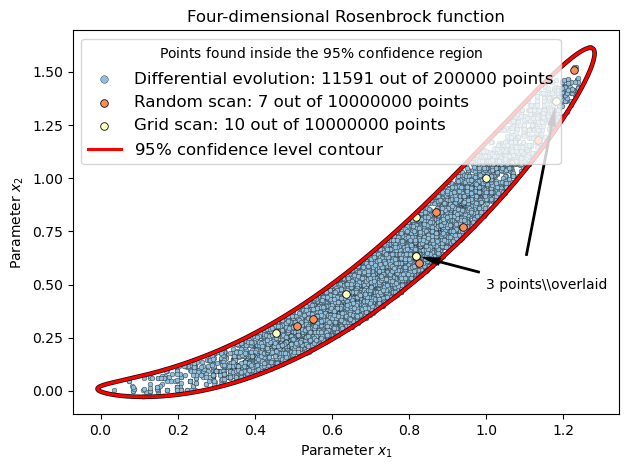

In [5]:
if __name__ == "__main__":

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Set plot styling
    #make_style()

    plt.figure()

    print("Running de_scan")
    t0 = time.time()
    x, calls = de_scan(dim, round_to_nearest=1000)
    de_time = time.time() - t0
    print("time = ", de_time)

    print("Plotting de_scan")
    plt.scatter(x[0][0], x[1][0], s=30, edgecolor='0.05',
                linewidth=0.25, alpha=1.0, facecolor=de_pts,
                label='Differential evolution: {:d} out of {:d} points'
                .format(x.shape[1], calls))
    plt.scatter(x[0][0], x[1][0], s=30, edgecolor='white',
                linewidth=0.25, alpha=1.0, facecolor="white")
    de_scatter = plt.scatter(x[0], x[1], s=12, edgecolor='0.05',
                             linewidth=0.25, alpha=1.0, facecolor=de_pts)

    print("Running random_scan")
    t0 = time.time()
    x, calls = random_scan(dim, n_random_samples)
    random_time = time.time() - t0
    print("time = ", random_time)

    print("Plotting random_scan")
    plt.scatter(x[0], x[1], s=30, edgecolor='0.05',
                linewidth=0.6, alpha=1.0, facecolor=rn_pts,
                label='Random scan: {:d} out of {:d} points'
                .format(x.shape[1], calls))

    print("Running grid_scan")
    t0 = time.time()
    x, calls = grid_scan(dim, n_random_samples)
    grid_time = time.time() - t0
    print("time = ", grid_time)

    print("Plotting grid_scan")
    plt.scatter(x[0], x[1], s=30, edgecolor='0.05',
                linewidth=0.6, alpha=1.0, facecolor=gd_pts,
                label='Grid scan: {:d} out of {:d} points'
                .format(x.shape[1], calls))

    plt.annotate('3 points\\\\overlaid', xy=(1, 0.48))
    plt.annotate('',
                 xy=(0.8181818181818183, 0.6363636363636358), xycoords='data',
                 xytext=(1, 0.55), arrowprops=dict(facecolor='black', shrink=0.1, width=1, headwidth=5))
    plt.annotate('',
                 xy=(1.1818181818181817, 1.3636363636363633), xycoords='data',
                 xytext=(1.1, 0.6), arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

    x1, x2, y = analytic_4d(critical_loglike)
    plt.plot(x1, y, c="0.05", lw=3.3)
    plt.plot(x2, y, c="0.05", lw=3.3)
    plt.plot(x1, y, c="red", lw=2.2)
    plt.plot(x2, y, c="red", lw=2.2,
             label=r"${0:.0f}\%$ confidence level contour".format(100. * beta))

    plt.ylabel("Parameter $x_2$")
    plt.xlabel("Parameter $x_1$")

    plt.title("Four-dimensional Rosenbrock function")
    plt.legend(title=r"Points found inside the ${0:.0f}\%$ confidence region".format(100. * beta),
               loc="upper left", fontsize=12)

    plt.tight_layout()

    plt.savefig("rosenbrock_vector.pdf")
    de_scatter.set_rasterized(True)
    plt.savefig("rosenbrock.pdf")


In [6]:
chi2.isf?

Signature: chi2.isf(q, *args, **kwds)
Docstring:
Inverse survival function (inverse of `sf`) at q of the given RV.

Parameters
----------
q : array_like
    upper tail probability
arg1, arg2, arg3,... : array_like
    The shape parameter(s) for the distribution (see docstring of the
    instance object for more information)
loc : array_like, optional
    location parameter (default=0)
scale : array_like, optional
    scale parameter (default=1)

Returns
-------
x : ndarray or scalar
    Quantile corresponding to the upper tail probability q.
File:      /usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py
Type:      method

In [8]:
chi2.isf(alpha,2)

5.991464547107983

In [10]:
differential_evolution?

Signature:
differential_evolution(
    func,
    bounds,
    args=(),
    strategy='best1bin',
    maxiter=1000,
    popsize=15,
    tol=0.01,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=None,
    callback=None,
    disp=False,
    polish=True,
    init='latinhypercube',
    atol=0,
    updating='immediate',
    workers=1,
    constraints=(),
    x0=None,
    *,
    integrality=None,
    vectorized=False,
)
Docstring:
Finds the global minimum of a multivariate function.

The differential evolution method [1]_ is stochastic in nature. It does
not use gradient methods to find the minimum, and can search large areas
of candidate space, but often requires larger numbers of function
evaluations than conventional gradient-based techniques.

The algorithm is due to Storn and Price [2]_.

Parameters
----------
func : callable
    The objective function to be minimized. Must be in the form
    ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
    and ``args`` is